# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to find a basic workflow for doing machine learning classification of an imbalanced dataset using best practices taken from other people's examples.

# Handling Class Imbalance with R and Caret

## References

**::GMG::** This notebook is a re-enactment of the following references:

  - [r-bloggers]() Handling Class Imbalance with R and Caret – Caveats when using the AUC. January 2, 2017. By [Wicked Good Data](http://dpmartin42.github.io/) - r ([Daniel P. Martin](http://dpmartin42.github.io/about), lead data scientist for the client-facing people analytics team at McKinsey & Company)
  - [Wicked Good Data](http://dpmartin42.github.io/posts/r/imbalanced-classes-part-2) Handling Class Imbalance with R and Caret - Caveats when using the AUC. January 03, 2017
  - [Wicked Good Data](http://dpmartin42.github.io/posts/r/imbalanced-classes-part-1) Handling Class Imbalance with R and Caret - An Introduction. December 10, 2016

## Libraries

In [1]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [2]:
#::GMG::I'm going to use ... 
#(dplyr) - for data manipulation
#(caret) - for model-building
#(DMwR)  - for smote implementation
#(purrr) - for functional programming (map)
#(pROC)  - for AUC calculations
#(PRROC) - for Precision-Recall curve calculations
#(gbm)   - for Generalized Boosted Regression Models
# https://cran.r-project.org/web/packages/gbm/index.html
using('dplyr', 'caret', 'DMwR','purrr', 'pROC', 'PRROC', 'gbm')

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: DMwR
Loading required package: grid
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: purrr

Attaching package: ‘purrr’

The following object is masked from ‘package:caret’:

    lift

Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: PRROC
Loading required package: gbm
Warning message in library(package, lib.loc = lib.loc, character.on

[[1]]
[1] TRUE

**::GMG::** First installation of `gbm`:

```R
Loading required package: gbm
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘gbm’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Loading required package: gbm
Loaded gbm 2.1.5

    1. TRUE
```

**::GMG::** First installation `DMwR` and `pROC`:

```R
Loading required package: DMwR
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DMwR’”
                           
Loading required package: pROC
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pROC’”
                           
Installing packages into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘TTR’, ‘xts’, ‘quantmod’, ‘zoo’

Loading required package: DMwR
Loading required package: grid
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

    1. TRUE
    2. TRUE

                           
```

## Dataset

In [3]:
set.seed(2969)

In [4]:
#::GMG::This function simulates data with two classes, truly important predictors and irrelevant predictions. 
# https://rdrr.io/rforge/caret/man/twoClassSim.html
imbal_train <- caret::twoClassSim(5000,
                           intercept = -25,
                           linearVars = 20,
                           noiseVars = 10)                           
imbal_test  <- caret::twoClassSim(5000,
                           intercept = -25,
                           linearVars = 20,
                           noiseVars = 10)

## Model

### base (Gradient Boost)

In [5]:
#::GMG::Set up control function for training
ctrl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 5,
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE)

In [6]:
#::GMG::Make it reproducble
set.seed(5627)

In [7]:
#::GMG::Build a standard classifier using a gradient boosted machine
orig_fit <- train(Class ~ .,
                  data = imbal_train,
                  method = "gbm",
                  verbose = FALSE,
                  metric = "ROC",
                  trControl = ctrl)

### weighted

In [8]:
#::GMG::Create model weights (they sum to one)
#::NOTE::I measure the time it takes
# https://www.r-bloggers.com/5-ways-to-measure-running-time-of-r-code/
start_time <- Sys.time()
model_weights <- ifelse(imbal_train$Class == "Class1",
                        (1/table(imbal_train$Class)[1]) * 0.5,
                        (1/table(imbal_train$Class)[2]) * 0.5)
end_time <- Sys.time()

In [ ]:
cat('calculating model weights has taken: ', end_time - start_time, ' mins.')

In [9]:
#::GMG::Use the same seed to ensure same cross-validation splits
#::NOTE::This might not be working (?) --> See last cells!
ctrl$seeds <- orig_fit$control$seeds

In [10]:
#::GMG::Weighted model
#::NOTE::I measure the time it takes
# https://www.r-bloggers.com/5-ways-to-measure-running-time-of-r-code/
start_time <- Sys.time()
weighted_fit <- train(Class ~ .,
                      data = imbal_train,
                      method = "gbm",
                      verbose = FALSE,
                      weights = model_weights,
                      metric = "ROC",
                      trControl = ctrl)
end_time <- Sys.time()

In [ ]:
cat('model weighted fit has taken: ', end_time - start_time, ' mins.')

### down(sampling)

In [11]:
ctrl$sampling <- "down"

In [12]:
#::NOTE::I measure the time it takes
# https://www.r-bloggers.com/5-ways-to-measure-running-time-of-r-code/
start_time <- Sys.time()
down_fit <- train(Class ~ .,
                  data = imbal_train,
                  method = "gbm",
                  verbose = FALSE,
                  metric = "ROC",
                  trControl = ctrl)
end_time <- Sys.time()

In [ ]:
cat('model downsampling fit has taken: ', end_time - start_time, ' mins.')

### up(sampling)

In [13]:
ctrl$sampling <- "up"

In [14]:
#::NOTE::I measure the time it takes
# https://www.r-bloggers.com/5-ways-to-measure-running-time-of-r-code/
start_time <- Sys.time()
up_fit <- train(Class ~ .,
                data = imbal_train,
                method = "gbm",
                verbose = FALSE,
                metric = "ROC",
                trControl = ctrl)
end_time <- Sys.time()

In [ ]:
cat('model upsampling fit has taken: ', end_time - start_time, ' mins.')

### smote

In [15]:
ctrl$sampling <- "smote"

In [16]:
#::NOTE::I measure the time it takes
# https://www.r-bloggers.com/5-ways-to-measure-running-time-of-r-code/
start_time <- Sys.time()
smote_fit <- train(Class ~ .,
                   data = imbal_train,
                   method = "gbm",
                   verbose = FALSE,
                   metric = "ROC",
                   trControl = ctrl)
end_time <- Sys.time()

In [ ]:
cat('model smote fit has taken: ', end_time - start_time, ' mins.')

## Evaluation

**::GMG::** Saito and Rehmsmeier (2015) recommend examining the precision-recall curve as it is more explicitly informative than a ROC curve in the case of imbalanced classes.

In [17]:
##::GMG:Examine results for test set
model_list <- list(original = orig_fit,
                   weighted = weighted_fit,
                   down = down_fit,
                   up = up_fit,
                   SMOTE = smote_fit)

In [18]:
#::GMG::We can calculate the area under the precision-recall curve for our 5 classifiers using the PRROC 
#       package in R to create a custom function, calc_auprc. 
calc_auprc <- function(model, data){
  
  index_class2 <- data$Class == "Class2"
  index_class1 <- data$Class == "Class1"
  
  predictions <- predict(model, data, type = "prob")
  
  pr.curve(predictions$Class2[index_class2], predictions$Class2[index_class1], curve = TRUE)
  
}

In [19]:
#::GMG::Get results for all 5 models
model_list_pr <- model_list %>%
  map(calc_auprc, data = imbal_test)

In [20]:
model_list_pr %>%
  map(function(the_mod) the_mod$auc.integral)

$original
[1] 0.5187951

$weighted
[1] 0.640687

$down
[1] 0.53057

$up
[1] 0.6246232

$SMOTE
[1] 0.6341753

**::GMG::** We have better performance for the weighted model, followed by the sampled models, with the original model coming in last. However, now the difference in performance is much more apparent.

Warning message:
“`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session.”

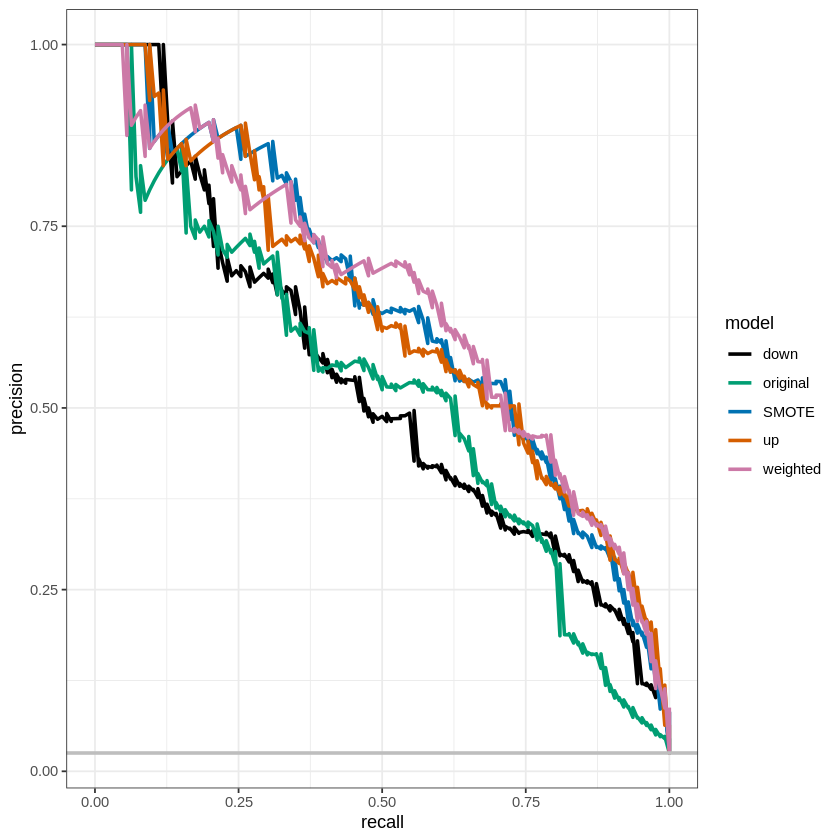

In [21]:
#::GMG::Plot the AUPRC curve for all 5 models
#::NOTE::We can dig deeper into these results by actually plotting the precision-recall curves.
results_list_pr <- list(NA)
num_mod <- 1

for(the_pr in model_list_pr){
  
  results_list_pr[[num_mod]] <- data_frame(recall = the_pr$curve[, 1],
                                           precision = the_pr$curve[, 2],
                                           model = names(model_list_pr)[num_mod])
  
  num_mod <- num_mod + 1
  
}

results_df_pr <- bind_rows(results_list_pr)

custom_col <- c("#000000", "#009E73", "#0072B2", "#D55E00", "#CC79A7")

ggplot(aes(x = recall, y = precision, group = model), data = results_df_pr) +
  geom_line(aes(color = model), size = 1) +
  scale_color_manual(values = custom_col) +
  geom_abline(intercept = sum(imbal_test$Class == "Class2")/nrow(imbal_test),
              slope = 0, color = "gray", size = 1) +
  theme_bw()

**::GMG::** There's a warning in this cell:

```R
Warning message:
“`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session.”
```

So [what](https://www.google.com/search?client=firefox-b-d&q=tibble()+versus+data.frame()) are [the differences](https://cran.rstudio.com/web/packages/tibble/vignettes/tibble.html) between `tibble()` and `data_frame()`?

**::GMG::** Discussion:

> we see that both up sampling and weighting offer the best precision and recall performance depending on the threshold that is chosen, while the original classifier is essentially the worst performing across all thresholds. For example, the weighted classifier simultaneously has a recall of 75% and a precision of 50%, resulting in an F1 score of 0.6, while the original classifier has a recall of 75% and a precision of 25%, resulting in an F1 score of 0.38. In other words, when both classifiers create their predictions and use a particular threshold to obtain hard classifications, they both correctly identify 75% of the cases that are actually in the minority class. However, the weighted classifier is more efficient in these predictions, in that 50% of the observations predicted to be in the minority class actually are, while for the original classifier, only 25% of the observations predicted to be in the minority class actually are.

## Caret custom metrics

**::GMG::** I want to choose hyperparameters of a classifier by using the area under the precision-recall curve rather than the AUC, as some combinations of hyperparameters for a given model might have better early retrieval performance compared to others. It's easy to create a *custom summary function* in caret to allow you to do this by combining the code for the `calc_auprc` function with [these instructions](https://topepo.github.io/caret/model-training-and-tuning.html#metrics) found in the caret documentation. 

In [22]:
#.:GMG::The custom summary function is implemented
auprcSummary <- function(data, lev = NULL, model = NULL){
  index_class2 <- data$obs == "Class2"
  index_class1 <- data$obs == "Class1"
  
  the_curve <- pr.curve(data$Class2[index_class2], data$Class2[index_class1], curve = FALSE)
  out <- the_curve$auc.integral
  names(out) <- "AUPRC"
  out  
}

In [23]:
#::GMG::Re-initialize control function to remove smote and
#       include our new summary function
ctrl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 5,
                     summaryFunction = auprcSummary,
                     classProbs = TRUE,
                     seeds = orig_fit$control$seeds)

In [24]:
#::NOTE::I measure the time it takes
# https://www.r-bloggers.com/5-ways-to-measure-running-time-of-r-code/
start_time <- Sys.time()
orig_pr <- train(Class ~ .,
                 data = imbal_train,
                 method = "gbm",
                 verbose = FALSE,
                 metric = "AUPRC",
                 trControl = ctrl)
end_time <- Sys.time()

In [ ]:
cat('model fit has taken: ', end_time - start_time, ' mins.')

In [25]:
#::GMG::Get results for auprc on the test set
orig_fit_test <- orig_fit %>%
  calc_auprc(data = imbal_test) %>%
  (function(the_mod) the_mod$auc.integral)
orig_pr_test <- orig_pr %>%
  calc_auprc(data = imbal_test) %>%
  (function(the_mod) the_mod$auc.integral)

In [26]:
#::GMG::The test errors are the same (?)
identical(orig_fit_test, orig_pr_test)

[1] FALSE

In [28]:
print(orig_fit_test)

[1] 0.5187951


In [29]:
print(orig_pr_test)

[1] 0.5034778


In [27]:
#::GMG::Because both chose the same hyperparameter combination (?)
identical(orig_fit$bestTune, orig_pr$bestTune)

[1] FALSE

In [30]:
print(orig_fit$bestTune)

  n.trees interaction.depth shrinkage n.minobsinnode
9     150                 3       0.1             10


In [31]:
print(orig_pr$bestTune)

  n.trees interaction.depth shrinkage n.minobsinnode
6     150                 2       0.1             10


## Final thoughts

> The area under the precision-recall curve can be a useful metric to help differentiate between two competing models in the case of imbalanced classes. For the AUC, weights and sampling techniques may only provide modest improvements. However, this improvement typically impacts early retrieval performance, resulting in a much larger gain in the overall precision of a model. In conjunction with trying weighting or sampling, it is also recommended to avoid relying solely on the AUC when evaluating the performance of a classifier that has imbalanced classes as it can be a misleading metric. The code above shows how easy it is to use the precision-recall curve, a more sensitive measure of classification performance when there are imbalanced classes.